In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
# Import stratifiedKFold
from sklearn.model_selection import KFold

In [2]:
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
def scale_data(data):
    scaler = StandardScaler()
    for col in data.columns:
        if is_numeric_dtype(data[col]):
            data[col] = scaler.fit_transform(data[[col]])
    return data

In [3]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9, 12.0]
c = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
d = [object, object, object, object, object, object, object, object, object, object]
data = {'a': a, 'b': b, 'c': c, 'd': d}
df = pd.DataFrame(data)
df = scale_data(df)
df

,a,b,c,d
0,-1.566699,-1.518325,a,<class 'object'>
1,-1.218544,-1.187601,b,<class 'object'>
2,-0.870388,-0.856876,c,<class 'object'>
3,-0.522233,-0.526152,d,<class 'object'>
4,-0.174078,-0.195428,e,<class 'object'>
5,0.174078,0.135296,f,<class 'object'>
6,0.522233,0.466021,g,<class 'object'>
7,0.870388,0.796745,h,<class 'object'>
8,1.218544,1.127469,i,<class 'object'>
9,1.566699,1.758852,j,<class 'object'>


In [4]:
def cross_validate_model(model, X, y):
    cv_strat = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X, y, cv=cv_strat, scoring=['neg_root_mean_squared_error'], return_train_score=True, return_estimator=True)
    return cv_results

In [5]:
def average_cv_results(cv_results):
    avg_results = {}
    print(cv_results.keys())
    for key in cv_results.keys():
        if key == 'estimator':
            continue
        avg_results[key] = cv_results[key].mean()
    # Get best estimator according to RMSE
    best_estimator_index = cv_results['test_neg_root_mean_squared_error'].argmax()
    best_estimator = cv_results['estimator'][best_estimator_index]
    return avg_results, best_estimator

In [6]:
def lazy_model(df, target, drop_cols=[]):
    from lazypredict.supervised import LazyRegressor
    X = df.drop(columns=[target] + drop_cols)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    return models

In [7]:
def feature_importance(model, X, y):
    model.fit(X, y)
    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    elif hasattr(model, 'coef_'):
        feature_importances = pd.DataFrame(model.coef_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    else:
        print('Model does not have feature importances')
    return feature_importances

In [8]:
def lime_regression(model, X_train, X_test, y_train, y_test):
    import lime
    import lime.lime_tabular
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='regression', training_labels=y_train.values, feature_names=X_train.columns)

    exp = explainer.explain_instance(X_test.values[0], model.predict, num_features=len(X_train.columns))
    return exp

In [9]:
def shap_values(model, X):
    import shap
    shap.initjs()
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    return shap_values

In [21]:
# Load the data from pkl
cf = pd.read_pickle('../../data/processed/cf_mc_ino_pino_of.pkl')
# get object columns
object_cols = cf.select_dtypes(include='object').columns
object_cols

Index(['lote', 'lote_parental_cf', 'id_bio_x', 'id_centr', 'id_bio_y',
       'orden'],
      dtype='object')

In [11]:

# Target is producto_1_cf
y = cf['producto_1_cf']
# Features are all columns except producto_1_cf
X = cf.drop(columns=['producto_1_cf'])
# Drop all columns which are not numeric
#X = X.select_dtypes(include=['number'])
drop_cols = ['producto_2_cf','lote', 'lote_parental_cf','id_bio_x', 'id_bio_y', 'id_centr', 'orden']
X = X.drop(columns=drop_cols)
# If a column is datetime drop it
import numpy as np
X = X.drop(columns=X.select_dtypes('datetimetz').columns)
X.shape, y.shape

((152, 36), (152,))

In [12]:
# Find NATType
X.dtypes.value_counts()
# print int 
X.select_dtypes(include=['int64']).columns

Index(['orden_encadenado_cf', 'dur_cf'], dtype='object')

In [13]:
cf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   lote                    152 non-null    object             
 1   orden_encadenado_cf     152 non-null    int64              
 2   lote_parental_cf        152 non-null    object             
 3   id_bio_x                152 non-null    object             
 4   f_h_inicio_cf           152 non-null    datetime64[ns, UTC]
 5   f_h_fin_cf              152 non-null    datetime64[ns, UTC]
 6   vol_ino_util_cf         147 non-null    float64            
 7   turb_inicio_cultivo_cf  152 non-null    float64            
 8   turb_fin_cultivo_cf     152 non-null    float64            
 9   viab_final_cultivo_cf   152 non-null    float64            
 10  id_centr                152 non-null    object             
 11  centr_1_turb_cf         148 non-null    float

In [20]:
# Perform cross validation
# Scale
# Drop turbidez_diff_cf
X = X.drop(columns=['turbidez_diff_cf', 'turbidez_fin_cultivo_cf'])
X = scale_data(X)
model = RandomForestRegressor(n_estimators=50, random_state=42)
cv_results = cross_validate_model(model, X, y)
avg_results, best_estimator = average_cv_results(cv_results)
print('test average RMSE:', avg_results['test_neg_root_mean_squared_error'])
print('train average RMSE:', avg_results['train_neg_root_mean_squared_error'])
print('best_estimator test RMSE:', cv_results['test_neg_root_mean_squared_error'].max())
print(feature_importance(best_estimator, X, y))

KeyError: "['turbidez_diff_cf', 'turbidez_fin_cultivo_cf'] not found in axis"

In [15]:

lazy_model(cf, 'producto_1_cf', drop_cols=drop_cols)

100%|██████████| 42/42 [00:00<00:00, 66.73it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 121, number of used features: 35
[LightGBM] [Info] Start training from score 1672.990337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
KernelRidge,112.00,-43.40,1724.27,0.01
MLPRegressor,95.62,-36.85,1592.02,0.04
LinearSVR,85.28,-32.71,1502.49,0.00
GaussianProcessRegressor,75.27,-28.71,1410.45,0.01
Lars,19.79,-6.52,709.52,0.01
RANSACRegressor,13.89,-4.16,587.59,0.04
DecisionTreeRegressor,6.69,-1.28,390.52,0.00
ExtraTreeRegressor,5.01,-0.61,327.91,0.00
QuantileRegressor,3.74,-0.10,270.97,0.01


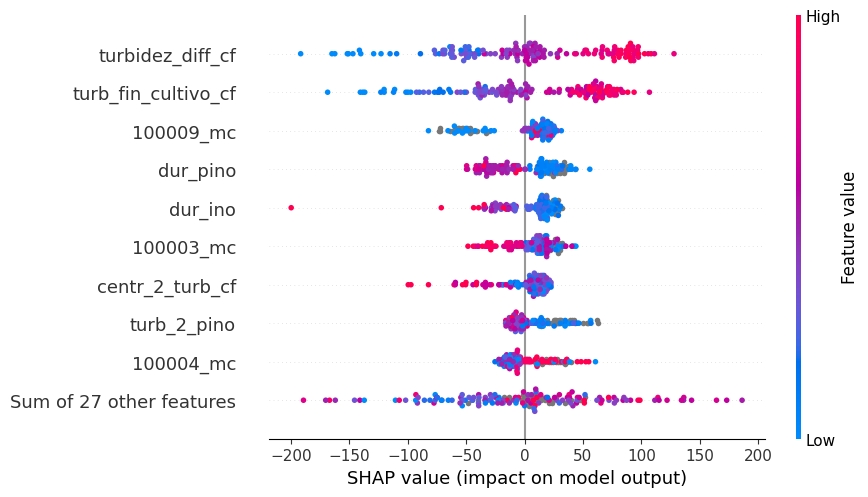

In [16]:
# shap
import shap
exp = shap_values(best_estimator, X)
shap.plots.beeswarm(exp)

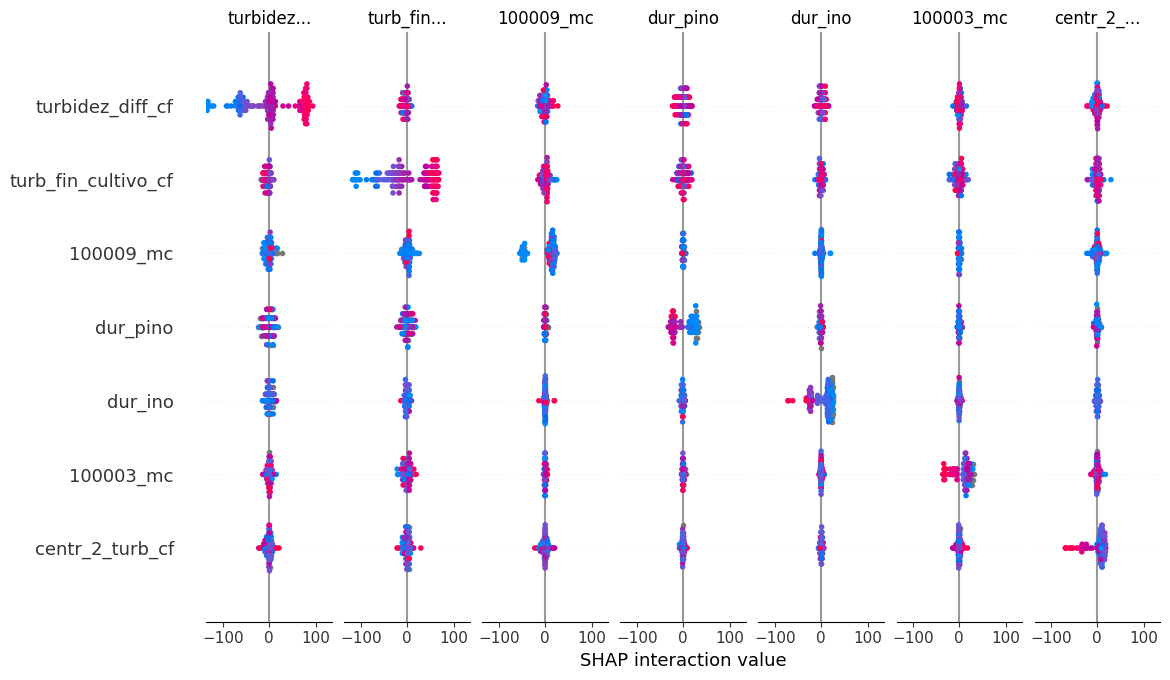

In [17]:
# Get interaction values
shap_interaction_values = shap.TreeExplainer(best_estimator).shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)
